## Udacity CharityML project

This notebook contains solution of Udacity CharityML project using Yandex CatBoost classifier,
a tool for gradient boosting on decision trees, which is well suited for categorical features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, FeaturesData, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score


The data contains 45221 records with census and income data (more or less than 50K)

In [2]:
data=pd.read_csv('census.csv')
print(data.iloc[1:5,:])

   age          workclass education_level  education-num       marital-status  \
1   50   Self-emp-not-inc       Bachelors           13.0   Married-civ-spouse   
2   38            Private         HS-grad            9.0             Divorced   
3   53            Private            11th            7.0   Married-civ-spouse   
4   28            Private       Bachelors           13.0   Married-civ-spouse   

           occupation    relationship    race      sex  capital-gain  \
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   capital-loss  hours-per-week  native-country income  
1           0.0            13.0   United-States  <=50K  
2           0.0            40.0   United-States  <=50K  
3           0.0            40.0   United-States  <=50K  
4    

We will construct a model that predicts the income based on the census data.
Start with data preprocessing. Replace the income column with 0 (less than 50K) and 1 (more than 50K)
Split train and test sets. Scale numerical features. Note that we do not need to do one-hot encoding for categorical features to use CatBoost.

In [3]:
data['income']=data['income'].apply(lambda x: (x=='>50K'))
features=data.drop(columns=['income'])
outcomes=data['income']
features_train,features_test, outcomes_train, outcomes_test=train_test_split(features,outcomes,test_size=0.2,random_state=23)
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler.fit(features[numerical])
features[numerical]=scaler.transform(data[numerical])


Initialize CatBoost classifier. Parameters:
- depth: maximal depth of decision trees
- iterations: number of decision trees
- cat_features: column indices that correspond to categorical features
- od_type: type of overfitting detector, here we set it to 'Iter' to evaluate loss on test set after every iteration
- od_wait: number of iterations to continue after the iteration with optimal loss value on the test set

In [4]:
cbclf=CatBoostClassifier(depth=9,iterations=3000,cat_features=[1,2,4,5,6,7,8,12],od_type='Iter',od_wait=300)

Create the Pool out of test data and train the classifier

In [5]:
testPool=Pool(data=features_test.values,label=outcomes_test.values,cat_features=[1,2,4,5,6,7,8,12])
cbclf.fit(features_train,outcomes_train,eval_set=testPool,verbose=False)

Learning rate set to 0.071069


Model evaluation:
- ROC auc score
- F1 score
- accuracy

In [6]:
y_train_pred=cbclf.predict_proba(features_train)[:, 1]
y_test_pred=cbclf.predict_proba(features_test)[:, 1]
print('Model ROC auc score on train set:',roc_auc_score(outcomes_train,y_train_pred))
print('Model ROC auc score on test:',roc_auc_score(outcomes_test,y_test_pred))
y_train_pred=y_train_pred>0.5
y_test_pred=y_test_pred>0.5
print('Model F1 score on train set:',f1_score(outcomes_train,y_train_pred))
print('Model F1 score on test set:',f1_score(outcomes_test,y_test_pred))
print('Model accuracy on train set:',accuracy_score(outcomes_train,y_train_pred))
print('Model accuracy on test set:',accuracy_score(outcomes_test,y_test_pred))



Model ROC auc score on train set: 0.937512782074
Model ROC auc score on test: 0.931060779985
Model F1 score on train set: 0.733495145631
Model F1 score on test set: 0.716055380131
Model accuracy on train set: 0.878596898582
Model accuracy on test set: 0.870757324489


Five most important features:

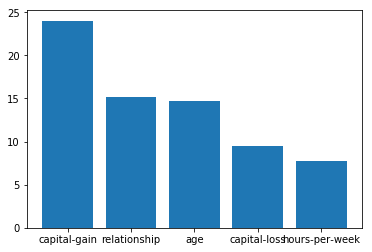

In [7]:
importances = cbclf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = features_train.columns.values[indices[:5]]
values = importances[indices][:5]

plt.bar(np.arange(5),values,tick_label=columns)
plt.show()
